In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, NuSVC
from scipy import stats
from constants import *
from auxiliary_functions import *
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from collections import namedtuple
from sklearn.decomposition import PCA
from os import cpu_count
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
process_data_files = False  # if set to False, data will be loaded from saved files

Load full users and taps datasets from Kaggle

In [9]:
from KaggleDataLoader import *

if not process_data_files:
    kaggle_taps = pd.read_csv(KAGGLE_TAPS_INPUT)
    print(kaggle_taps.head())
    kaggle_users = pd.read_csv(KAGGLE_USERS_INPUT)
    print(kaggle_users.head())

else:
    # Create dataframe from files, perform basic cleaning
    kaggle_users = create_merged_users_details_file()
    print(kaggle_users.head())
    
    kaggle_taps = create_merged_taps_dataframe()
    kaggle_taps = clean_bad_values(kaggle_taps)
    kaggle_taps = clean_incompatible_user_ids(kaggle_taps, kaggle_users)
    print(kaggle_taps.head())
    
    
    # Filter outliers
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    
    def plot_percentiles_of_column(df, col, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[col], x) for x in X]
        plt.plot(X, Y)
        plt.title(col + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    # Filter out outliers of HoldTime:
    plot_percentiles_of_column(kaggle_taps, 'HoldTime', 99.96, 99.9999, 20)
    # After the percentile 99.993 we see significantly higher values, which are definitely outliers.
    kaggle_taps = filter_column_by_quantile(kaggle_taps, 'HoldTime', 99.993)
    
    # Add parsed date and time column + calculate cumulative time
    kaggle_taps = add_cumulative_timestamps_column(kaggle_taps)
    
    
    # Group to bin indexes by the cumulative timestamps
    def build_bins(df, bin_size_seconds):
        df["PressTimeCumulative"] = df["PressTimeCumulative"] / 1000
        max_press = (int(max((df["PressTimeCumulative"])) / bin_size_seconds) + 1) * bin_size_seconds + 1
        user_bins = [i for i in range(0, max_press, bin_size_seconds)]
        df["binIndex"] = pd.cut((df["PressTimeCumulative"]), user_bins)
        return df
    
    
    kaggle_taps = build_bins(kaggle_taps, 90)
    
    # Keep only necessary columns and save to file
    kaggle_taps = kaggle_taps[TAPS_FINAL_COLUMNS + ['binIndex']]
    print(kaggle_taps.head())
    
    kaggle_taps.to_csv(constants.KAGGLE_TAPS_INPUT, index=False)

   Unnamed: 0  FlightTime  HoldTime Hand          ID Direction  LatencyTime  \
0           0       156.3     101.6    L  0EA27ICBLF        LL        234.4   
1           1       359.4      85.9    L  0EA27ICBLF        LL        437.5   
2           2       125.0      78.1    L  0EA27ICBLF        LL        210.9   
3           3       281.3      62.5    L  0EA27ICBLF        LL        359.4   
4           4        93.8     125.0    S  0EA27ICBLF        LS        187.5   

  binIndex  
0  (0, 90]  
1  (0, 90]  
2  (0, 90]  
3  (0, 90]  
4  (0, 90]  
   Unnamed: 0  BirthYear     DA DiagnosisYear  Gender          ID  Impact  \
0           0     1952.0   True          2000  Female  0EA27ICBLF  Severe   
1           1     1959.0  False        ------  Female  0QAZFRHQHW  ------   
2           2     1946.0  False        ------  Female  0WTDIGPSBZ  ------   
3           3     1944.0  False        ------    Male  1HOEBIGASW  ------   
4           4     1953.0  False          2017    Male  1WMVCCU

Load full users and taps datasets from MIT dataset

In [10]:
from MITDataLoader import *

if not process_data_files:
    mit_taps = pd.read_csv(MIT_TAPS_INPUT)
    print(mit_taps.head())
    mit_users = pd.read_csv(MIT_USERS_INPUT)
    print(mit_users.head())

else:
    mit_users = pd.read_csv(USERS, delimiter=',', header=0, error_bad_lines=False,
                            low_memory=False, usecols=["pID", "gt", "updrs108", "file_1", "file_2"])
    
    mit_taps = create_merged_taps_dataframe()
    mit_taps = clean_errors_and_bad_values(mit_taps)
    
    # Group to bin indexes by pressTime and add as a new column
    bin_size_seconds = 90
    max_press = (int(max(mit_taps["pressTime"]) / bin_size_seconds) + 1) * bin_size_seconds + 1
    user_bins = [i for i in range(0, max_press, bin_size_seconds)]
    mit_taps["binIndex"] = pd.cut(mit_taps["pressTime"], user_bins)
    print(mit_taps.head())
    
    
    # Filter outliers
    
    def plot_percentile(df, column, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[column], x) for x in X]
        plt.plot(X, Y)
        plt.title(column + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
    
    
    if SHOW_PLOTS:
        for col in list(set(FLOAT_COLUMNS) - {"pressTime"}):
            plot_percentile(mit_taps, col, 98, 99.9999, 40)
    
    # Filter according to the results in the plots
    filter_column_by_quantile(mit_taps, "HoldTime", 99.99)
    filter_column_by_quantile(mit_taps, "LatencyTime", 99.4)
    filter_column_by_quantile(mit_taps, "FlightTime", 99.95)
    
    # Save to file - Taps file
    mit_taps[["HoldTime", "LatencyTime", "FlightTime"]] = \
        1000 * mit_taps[["HoldTime", "LatencyTime", "FlightTime"]]  # to milliseconds
    print(mit_taps.head())
    
    mit_taps.to_csv(MIT_TAPS_INPUT, index=False)
    
    # Save to file - Users file
    mit_users.rename(columns={'pID': 'ID', 'gt': 'Parkinsons', 'updrs108': 'UDPRS'}, inplace=True)
    mit_users = mit_users[['ID', 'Parkinsons', 'UDPRS']]
    print(mit_users.head())
    
    mit_users.to_csv(MIT_USERS_INPUT, index=False)


   ID Hand Direction  HoldTime  LatencyTime  FlightTime  pressTime binIndex
0  68    L        RL     133.7        590.4       471.0     2.4218  (0, 90]
1  68    L        LL     184.7        473.1       339.4     2.8949  (0, 90]
2  68    L        LL     149.9        346.4       161.7     3.2413  (0, 90]
3  68    R        LR     213.7        720.3       570.4     3.9616  (0, 90]
4  68    R        RR     164.3       2505.7      2291.9     6.4673  (0, 90]
   ID  Parkinsons  UDPRS
0  11        True  14.25
1  60       False   2.00
2  67        True  25.25
3  68       False   6.00
4  70        True  26.25


#Feature Creation

##1.Creating features from the Kaggle data set, according to the first method:

In [11]:
# Load the raw data, after cleaning:
from method1_feature_extraction import *

raw_kaggle_data = pd.read_csv(KAGGLE_TAPS_INPUT)
kaggle_users_data = pd.read_csv(KAGGLE_USERS_INPUT)

In [12]:
# For every patient, calculate summary statistics for all of their data, partitioned into Left/Right, 
# and LR/RL/LL/RR transitions: 
method1_features = create_summary_statistics(raw_kaggle_data,
                                             columns_to_aggregate=["FlightTime", "HoldTime", "LatencyTime"],
                                             aggregation_functions=[np.mean, np.std, stats.kurtosis, stats.skew,
                                                        stats.entropy, percnt10, percnt20, percnt40, percnt60, percnt70,
                                                        percnt80, percnt90])
# Add a feature of the mean-diff between Left and Right HoldTimes, and Between LR and RL LatencyTimes:
method1_features["mean_diff_L_R_HoldTime"] = method1_features.R_HoldTime_mean - method1_features.L_HoldTime_mean
method1_features["mean_diff_LR_RL_LatencyTime"] = method1_features.RL_LatencyTime_mean - method1_features.LR_LatencyTime_mean
method1_features["mean_diff_LL_RR_LatencyTime"] = method1_features.LL_LatencyTime_mean - method1_features.RR_LatencyTime_mean

# Join with the Users data:
method1_features = method1_features.merge(kaggle_users_data, on="ID", how="left")
# Dump to csv:
method1_features.to_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
print(method1_features.head())

           ID  L_FlightTime_mean  L_FlightTime_std  L_FlightTime_kurtosis  \
0  0EA27ICBLF         239.655394        107.822976              -1.263192   
1  0QAZFRHQHW         319.277429        162.896291              -0.659685   
2  1HOEBIGASW         386.722581        175.209404              -0.927794   
3  1XNJCXS3EY         226.013786         85.352172              -0.493719   
4  2JTCBKUP8T         265.411441        160.215877              -0.093353   

   L_FlightTime_skew  L_FlightTime_entropy  L_FlightTime_percnt10  \
0          -0.032858             11.148338                   93.8   
1           0.361020              6.322468                  117.2   
2          -0.326568              3.319654                  132.8   
3          -0.125464              6.045913                  113.3   
4           0.540118              8.959632                   54.7   

   L_FlightTime_percnt20  L_FlightTime_percnt40  L_FlightTime_percnt60  \
0                  125.0                 203.10 

In [13]:
# Filter the data so that we only keep patients with plenty of tapping events, and only patients with mild Parkinsons:
method1_features = method1_features[method1_features.total_count >= TAPS_THRESHOLD]  # take only users with more than THRESHOLD keystrokes
method1_features = method1_features[method1_features.Levadopa == False]
method1_features = method1_features[method1_features.Parkinsons == False | ( (method1_features.Parkinsons == True) & (method1_features.Impact == "Mild"))]


#Modeling Phase 1: Attempting to reproduce the results from the Kaggle challenge article

In [15]:
# The summary statistics used in the original article:
ARTICLE_EXPLANATORY_VARIABLES =['L_HoldTime_mean', 'L_HoldTime_std', 'L_HoldTime_kurtosis', 'L_HoldTime_skew',
 'R_HoldTime_mean', 'R_HoldTime_std', 'R_HoldTime_kurtosis', 'R_HoldTime_skew', 'LL_LatencyTime_mean', 'LL_LatencyTime_std',
 'LL_LatencyTime_kurtosis', 'LL_LatencyTime_skew', 'LR_LatencyTime_mean', 'LR_LatencyTime_std', 'LR_LatencyTime_kurtosis',
 'LR_LatencyTime_skew', 'RL_LatencyTime_mean', 'RL_LatencyTime_std', 'RL_LatencyTime_kurtosis', 'RL_LatencyTime_skew',
 'RR_LatencyTime_mean', 'RR_LatencyTime_std', 'RR_LatencyTime_kurtosis', 'RR_LatencyTime_skew', 'mean_diff_LR_RL_LatencyTime',
 'mean_diff_LL_RR_LatencyTime', 'mean_diff_L_R_HoldTime']




### First attempt: applying several models to the raw data with the variables used in the article, without further processing:


In [16]:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),
               SVC(kernel='rbf', probability=True),
               ]
for clf in classifiers:
    accuracy = evaluate_classifier_cv(clf, X, y, cross_validation_folds=5)
    print(str(clf).split("(")[0]+":")
    print("\t"+accuracy.train)
    print("\t" + accuracy.test)

LogisticRegression:
	Train accuracy:0.7885
	Test accuracy (5-fold cross validation):0.4945
RandomForestClassifier:
	Train accuracy:0.9808
	Test accuracy (5-fold cross validation):0.5382


AdaBoostClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.4945
KNeighborsClassifier:
	Train accuracy:0.6538
	Test accuracy (5-fold cross validation):0.5982


GradientBoostingClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.4836
SVC:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6345


we can see that all models are highly overfitted, and do not perform well.

### Second attempt: normalize the data and apply PCA dimensionality reduction

In [17]:
scaler = StandardScaler()
normalized_X = scaler.fit_transform(X)

AttributeError: 'NoneType' object has no attribute 'sqrt'

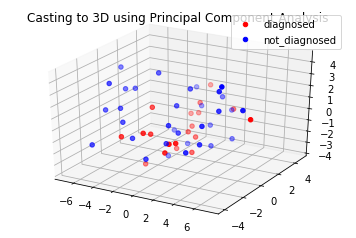

In [18]:
# Visualizing the data in 3d, 2d and 1d after PCA:
pca = PCA(n_components=3)
reduced_X = pca.fit_transform(normalized_X)
plot_labeled_data_3d(reduced_X, y, "Casting to 3D using Principal Component Analysis")


pca = PCA(n_components=2)
reduced_X = pca.fit_transform(normalized_X)
plot_labeled_data_2d(reduced_X, y, "Casting to 2D using Principal Component Analysis")


pca = PCA(n_components=1)
reduced_X = pca.fit_transform(normalized_X)
plot_labeled_data_1d(reduced_X, y, "Casting to 1D using Principal Component Analysis")

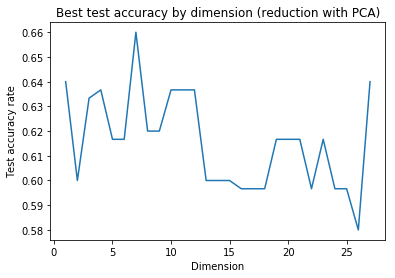

In [19]:
original_dim = len(normalized_X[0])
tested_dimensions = []
accuracies = []
for dim in [i for i in range(1, original_dim+1)]:
    if dim != original_dim:
        pca = PCA(n_components=dim)
        reduced_X = pca.fit_transform(normalized_X, y.values)
    else:
        reduced_X = normalized_X
    best_accuracy = namedtuple("best_accuracy", "clf_name test_accuracy train_accuracy")
    best_accuracy.test_accuracy = -1  #init
    for clf in classifiers:
        accuracy = evaluate_classifier_cv(clf, reduced_X, y, cross_validation_folds=10)
        if accuracy.test_score > best_accuracy.test_accuracy:
            best_accuracy.test_accuracy = accuracy.test_score
            best_accuracy.clf_name = str(clf).split("(")[0]
    tested_dimensions.append(dim)
    accuracies.append(best_accuracy.test_accuracy)
plt.title("Best test accuracy by dimension (reduction with PCA)")
plt.xlabel("Dimension")
plt.ylabel("Test accuracy rate")
plt.plot(tested_dimensions, accuracies)


We can see that PCA dimensionality reduction does not improve prformance.

C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [18]:
# Apply LDA dim-reduction and scaling to the data, and randomly split test and train sets:

# TODO: this section and the next one have very variable results (some runs even get AUC of 0.8...). maybe use K-fold-CV to reduce variance.


train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                               train_percentage=0.7)

# Fit several models, and find the best one by AUC measure:
best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
print("best AUC after LDA dimensionality reduction:", best_auc, " (by model: {})".format(type(best_clf).__name__))


# TODO:
    #1. fix warnings here -Done
    #2. continue with splititing to two groups, and exactly following the first article - Done
    #3. add the feature extraction of the second method (nqi features)
    #4. continue to second method.

best AUC after LDA dimensionality reduction: 0.7166666666666667  (by model: LogisticRegression)


C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\yoav1\PycharmProjects\Parkinsons\auxiliary_functions.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoav1\PycharmProjects\Parkinsons\auxiliary_functions.py:27: DataConversionWarning: 

It is evident that neither technique of dimensionaliy reduction improves performance. 
We now explore adding additional predictors, specifically calculating percentles of the HoldTime and LatencyTime, trying to better describe the distribution of these measures for each patient:

In [19]:
PERCENTILES = [c for c in method1_features.columns.values if "perc" in c and "FlightTime" not in c]
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES + PERCENTILES]
y = method1_features["Parkinsons"]

train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                               train_percentage=0.7)
# Fit several models, and find the best one by AUC measure:
best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
print("best AUC with additional variables:", best_auc, " (by model: {})".format(type(best_clf).__name__))

best AUC with additional variables: 0.6875  (by model: LogisticRegression)


C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\yoav1\PycharmProjects\Parkinsons\auxiliary_functions.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoav1\PycharmProjects\Parkinsons\auxiliary_functions.py:27: DataConversionWarning: 

We now continue to follow the method descdribed in the article, by partitioning the data into two groups, Hold variables and Latency variables (depending on the orignal column they were created by). 
We then assign a Parkinson's probability using each group seperately, and output a final probability as a weighted average of these two probabilities.

In [20]:
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
import warnings

ALL_VARIABLES = ARTICLE_EXPLANATORY_VARIABLES
HOLD_VARIABLES = [v for v in ALL_VARIABLES if "HoldTime" in v]
LATENCY_VARIABLES = [v for v in ALL_VARIABLES if "LatencyTime" in v]

voting_ensemble = VotingClassifier(estimators=[
                                    ('1', RandomForestClassifier()),
                                    ('2', SVC(probability=True)),
                                    ('3', MLPClassifier()),
                                    ('4', LogisticRegression()),
                                    ('5', NuSVC(probability=True)),
                                    ('6', KNeighborsClassifier()),
                                    ('7', DecisionTreeClassifier()),
                                    ('8', QuadraticDiscriminantAnalysis())
                                  ],
                        voting='soft')


def weighting_function(hold_probs, latency_probs):
    """
    These are the weights described in the article. We note that this weighting can yield probs > 1, and therefore is not optimal. 
    We've tried other weightings as well, with no significant improvement.
    """
    return (hold_probs + 0.5*(1-1.2) + 1.2*latency_probs)/2.0


groups_model = TwoGroupsWeightedModel(underlying_estimator_module_and_class="sklearn.pipeline Pipeline",
                            group1_var_names=HOLD_VARIABLES,
                            group2_var_names=LATENCY_VARIABLES,
                             weighting_function=weighting_function,              
                            classification_threshold=0.5,
                            steps=[("normalization", StandardScaler()),
                                   ("lda", LinearDiscriminantAnalysis()),
                                   ("clf", voting_ensemble)])

# calculate accuracy and AUC for the groups-model, using K-fold CV:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]

"""
Training the model on this data results in a "Collinear Variables" warnings. This is true, as some of the variables have very high Pearson-correlation.
In order to reporoduce the article findings we ignore these erros for now, and  filter warnings for the next few lines. 
"""
warnings.filterwarnings("ignore")
test_auc = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='roc_auc').test_score
test_accuracy = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='accuracy').test_score
warnings.resetwarnings()

print("Test AUC: {}\nTest Accuracy: {}".format(test_auc, test_accuracy))

Test AUC: 0.5326984126984128
Test Accuracy: 0.49818181818181817


Conclusion: in the above section we tried to reproduce and improve the classifying technique described in the article that inspired the Kaggle challenge. 
We believe that the the results in the aticle are not valid and non-reproducible, and we ellaborate further on this in the project document.

In [73]:
#Modeling Phase 2: A completely different approah, inspired by results published by a team of MIT researchers

pandas.core.frame.DataFrame